# Look at the Big Picture
Build a model of housing prices in California using the California census data.    
It should:
- Learn from provided data
- Predict the median housing price in any district



# Frame the Problem
Questions that help frame the problem, select algorithms and determine what performance measure to use for evaluating the model and how much effort to spend tweaking it:
- What is the business objective?
- How does the company expect to use and benefit from this model?

**In this case, the model's output will be fed to another ML system along with many other signals to determine whether it's worth investing in a given area or not. It's very important to get this right because it has a direct effect on revenue.**

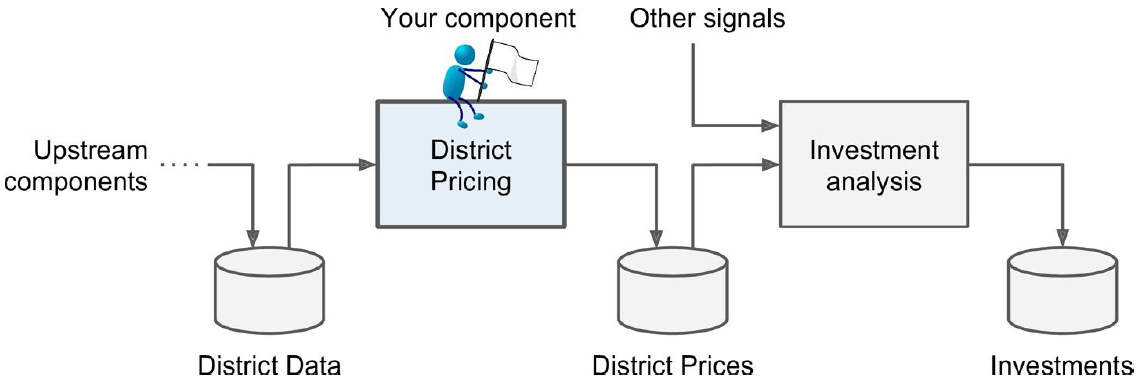


## Next Steps
1. What is the current solution (is there one)?
The district housing prices are currently estimated manually by experts.
A team gathers up-to-date information about a district (excluding median housing prices) and they use complex rules to come up with an estimate. The typical error rate is about 15%.

**Time to start designing the system**
1. Is the problem supervised, unsupervised, or Reinforcement Learning?
It's a typical supervised learning task. We are given labeled training examples (i.e. the district's median housing price).
2. Is it a classification task, a regression task or something else? 
It's a regression task because we need to predict a value. More specifically, it's a multivariate regression problem since the system will use multiple features to make a prediction (district's population, the median income, etc.).
3. Should you use batch or online learning techniques?
There's no continuous flow of data coming in the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory. Plain batch learning is fine.



# Select a Performance Measure
## Root Mean Square Error
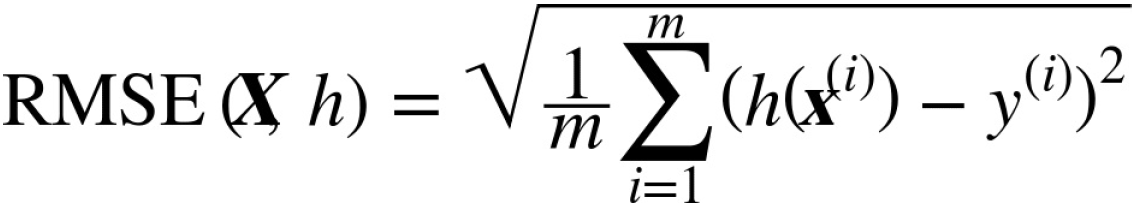

## Mean Absolute Error
In case of many outliers, it's better to use the Mean Absolute Error cost function.
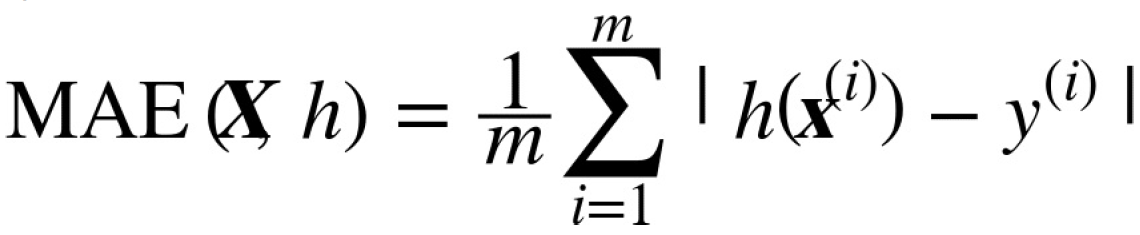


# Check the Assumptions 
List and verify the assumptions that were made so far to catch potential issues. For example, the district prices that your system outputs are going to be fed into a downstream ML system and we assume that these prices are going to be used as such. But what if the downstream system actually converts the prices into categories (e.g., "cheap", "medium" or "expensive") and then uses those categories instead of the prices themselves? 
In this case, getting the price perfectly right is not important at all. If that's so, then the problem should have been framed as a **classification** task, not a **regression** task.
 

# Create the Workspace
We are using Google Colab's built-in workspace as our training environment. 


# Download the Data


In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, 
                       housing_path=HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()


fetch_housing_data()

# Load the Data

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)


Examine the data

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


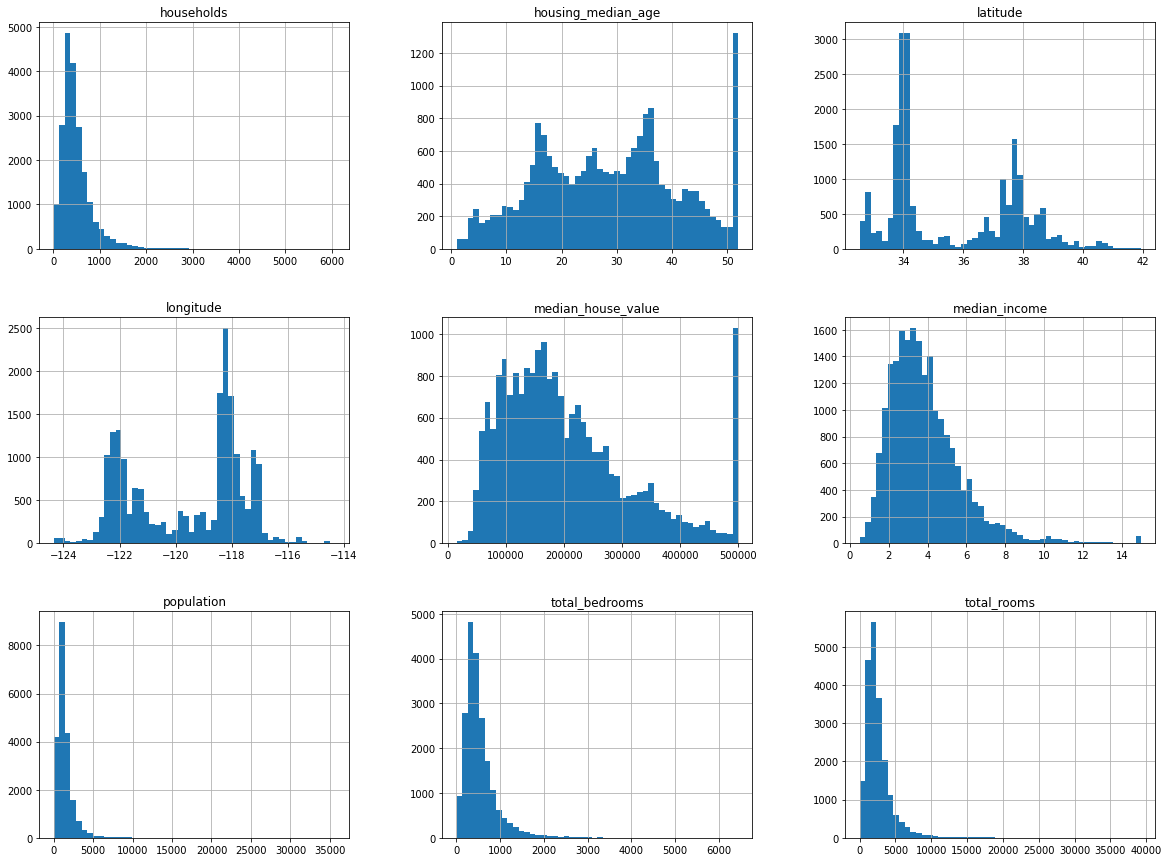

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

# Create a Test Set

In [9]:
import numpy as np

def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


In [11]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32

def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
housing_with_id = housing.reset_index() 
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

# OR combine longitude and latitude into an id
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [13]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

## Random Sampling Methods
Fine for large datasets (relative to the number of attributes).
For smaller datasets, there's a risk of sampling bias.

## Stratified Sampling
The population is divided into homogeneous subgroups called strata, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population. 


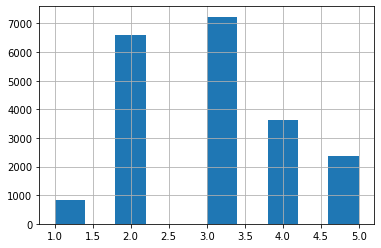

In [14]:
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, 
                               test_size=0.2,
                               random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]


In [16]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

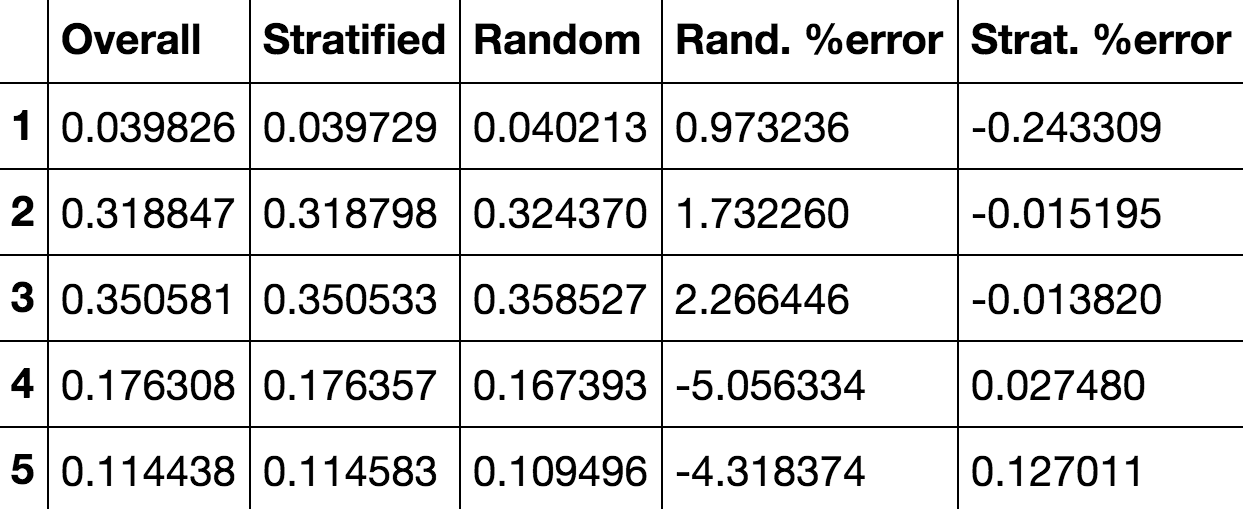

Drop the income_cat attribute so the data returns to its original state.

In [17]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)


# Discover and Visualize the Data to Gain Insights


When you have a very large dataset, it's good to create an exploration set to make manipulations easier and faster. In this case, our dataset is relatively small so we can go ahead and make a copy to play with it without harming the original training set.

In [18]:
housing = strat_train_set.copy()

## Visualizing Geographical Data


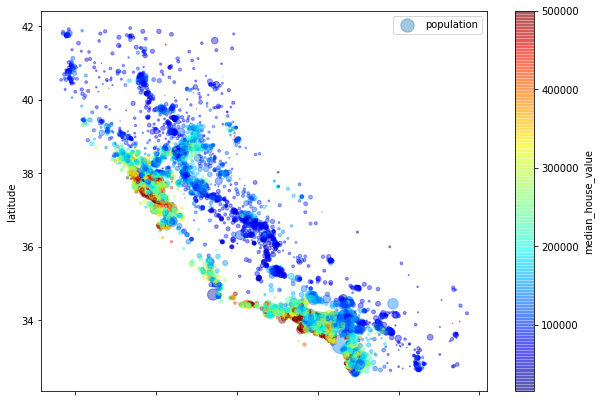

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

## Looking for Correlations


In [20]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The correlation coefficient only measures linear correlations ("if x goes up, then y generally goes up/down").

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf39c41048>,
      dtype=object)

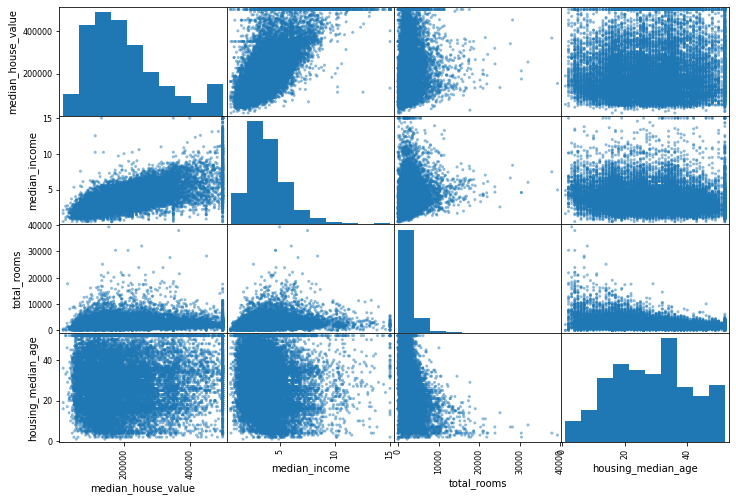

In [21]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

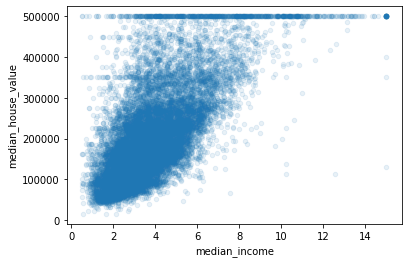

In [22]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

## Experimenting with Attribute Combinations


In [23]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithms


In [24]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()


## Data Cleaning


In [25]:
housing.dropna(subset=["total_bedrooms"]) # option 1
housing.drop("total_bedrooms", axis=1) # option 2
median = housing["total_bedrooms"].median() # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

Filling missing values with Scikit-Learn's SimpleImputer class. 

In [26]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)

imputer.statistics_
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [27]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

## Handling Text and Categorical Attributes

In [28]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)


,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [29]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [30]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One-hot encoding

In [31]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

## Custom Transformers

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

## Feature Scaling
Two ways to transform all attributes to the same scale: 
1. min-max scaling
2. standardization

### Min-max Scaling (Normalization)
The values are shifted and rescaled to end up ranging from 0 to 1.
To do this, we need to subtract the min value and divide by the max minus the min. 

### Standardization 
It subtracts the mean value, and then it divided by the standard deviation so that the resulting distribution has unit variance. 

> It's important to fit the scalers to the training data only. 

## Transformation Pipelines 


In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy="median")),
                         ('attribs_added', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

Handling all columns at the same time

In [34]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                                   ("num", num_pipeline, num_attribs),
                                   ("cat", OneHotEncoder(), cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing)

# Select and Train a Model
## Training and Evaluating on the Training Set
### Example 1: Linear Regression Model

In [38]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [43]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

### Example 2: DecisionTreeRegressor

In [44]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## Better Evaluation Using Cross-Validation

In [45]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [46]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: " , scores.mean())
    print("Standard deviation: " , scores.std())

display_scores(tree_rmse_scores)

Scores:  [69037.06056893 67226.18063671 71249.56420521 69565.78402841
 71043.40119236 75132.4280806  70980.27567818 70409.9849956
 79235.43086719 69640.19635294]
Mean:  71352.0306606119
Standard deviation:  3256.894003008588


In [48]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard deviation:  2731.674001798344


### Example 3: RandomForestRegressor

In [53]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18629.178106771327

In [54]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [49764.5133365  47303.30969915 50243.60505274 52480.38890398
 49785.44537506 53251.3408607  48931.86917284 48025.04874105
 52735.97556452 49642.56701414]
Mean:  50216.406372067104
Standard deviation:  1906.380223173443


# Fine-Tune Your Model

## Grid Search

In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'n_estimators': [3, 10, 30],
               'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10],
               'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid,
                           cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [56]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [57]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [58]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64623.06555542844 {'max_features': 2, 'n_estimators': 3}
55385.095881344416 {'max_features': 2, 'n_estimators': 10}
53085.281469642694 {'max_features': 2, 'n_estimators': 30}
60103.27878991899 {'max_features': 4, 'n_estimators': 3}
53346.36993509674 {'max_features': 4, 'n_estimators': 10}
50548.62251788413 {'max_features': 4, 'n_estimators': 30}
58690.16120854387 {'max_features': 6, 'n_estimators': 3}
52228.19969312529 {'max_features': 6, 'n_estimators': 10}
50115.579964941724 {'max_features': 6, 'n_estimators': 30}
59043.7308445204 {'max_features': 8, 'n_estimators': 3}
51668.2305625361 {'max_features': 8, 'n_estimators': 10}
49974.11641038227 {'max_features': 8, 'n_estimators': 30}
61714.198975926156 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54661.458958822644 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59033.281592577296 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52612.641714494945 {'bootstrap': False, 'max_features': 3, 'n_estimators

## Randomized Search
If you have a large hyperparameter search space it's better to use RandomizedSearchCV for two main reasons:
1. If you let the randomized search run for n iterations, it will explore n different values for each hyperparameter instead of just a few values like the Grid Search.
2. By setting the number of iterations, you have more control over the computing budget you want to allocate to hyperparameter search. 

## Ensemble Methods
Combine the models that perform best. 


## Analyze the Best Models and Their Errors


In [59]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.81889434e-02, 5.92183299e-02, 4.56069395e-02, 1.51838690e-02,
       1.42120025e-02, 1.45090212e-02, 1.50176690e-02, 3.65522774e-01,
       5.43960309e-02, 1.12964196e-01, 6.49324539e-02, 8.46003247e-03,
       1.56142225e-01, 7.55038240e-05, 1.84551850e-03, 3.72449030e-03])

In [60]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)


[(0.365522774161125, 'median_income'),
 (0.15614222518368195, 'INLAND'),
 (0.11296419630783082, 'pop_per_hhold'),
 (0.06818894341720311, 'longitude'),
 (0.06493245387816399, 'bedrooms_per_room'),
 (0.05921832989501875, 'latitude'),
 (0.05439603093853552, 'rooms_per_hhold'),
 (0.045606939497065, 'housing_median_age'),
 (0.015183869005015319, 'total_rooms'),
 (0.01501766898539515, 'households'),
 (0.014509021171020795, 'population'),
 (0.01421200246854561, 'total_bedrooms'),
 (0.008460032469685456, '<1H OCEAN'),
 (0.0037244903017273697, 'NEAR OCEAN'),
 (0.0018455184959694627, 'NEAR BAY'),
 (7.550382401664081e-05, 'ISLAND')]

## Evaluate Your System on the Test Set


In [62]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47928.085742354466

In [64]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2 
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                          loc=squared_errors.mean(),
                          scale=stats.sem(squared_errors)))

array([45921.9234359 , 49853.58315909])